In [11]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

# 1. FER2013 

### 1.1 Dataset informations

The data set used for training is the Kaggle FER2013 emotion recognition data set : https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image.

Seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

### 1.2 Dataset exploration

In [66]:
path = "../Data/"

In [64]:
dataset = pd.read_csv(path + "fer2013.csv")

train = dataset[dataset["Usage"] == "Training"]
test = dataset[dataset["Usage"] == "PublicTest"]

In [38]:
train

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,Training
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...,Training
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,Training
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,Training


In [39]:
pd.options.mode.chained_assignment = None  # default='warn'  #to suppress SettingWithCopyWarning

In [40]:
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
dataset['pixels'] = dataset['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

In [41]:
dataset.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [42]:
dataset['emotion']

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

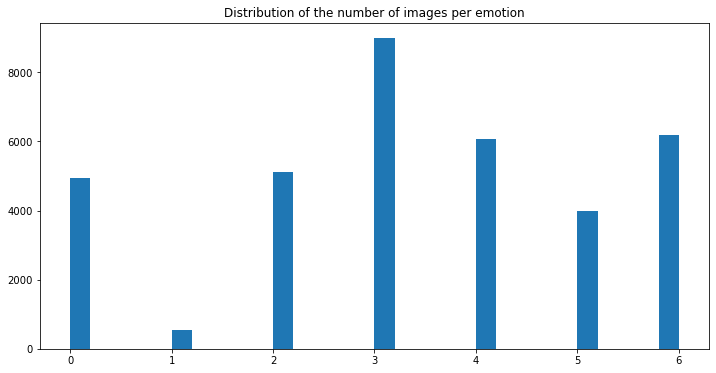

In [43]:
plt.figure(figsize=(12,6))
plt.hist(dataset['emotion'], bins=30)
plt.title("Distribution of the number of images per emotion")
plt.show()

In [44]:
print(train.shape)
print(test.shape)

(28709, 3)
(3589, 3)


## 1.3 Loading and preprocessing

In [45]:
shape_x = 48
shape_y = 48

In [46]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values

X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

X = dataset.iloc[:,1].values
y = dataset.iloc[:,0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

X = np.reshape(X, (X.shape[0],48,48,1))
y = np.reshape(y, (y.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [47]:
# Change to float datatype
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X = X.astype('float32')

# Scale the data to lie between 0 to 1
X_train /= 255
X_test /= 255
X /= 255

# Change the labels from integer to categorical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y = to_categorical(y)

In [49]:
#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

In [53]:
X_test.shape

(3589, 48, 48, 1)

In [55]:
y_test[1500]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

Text(0.5, 1.0, 'Ground Truth : Neutral')

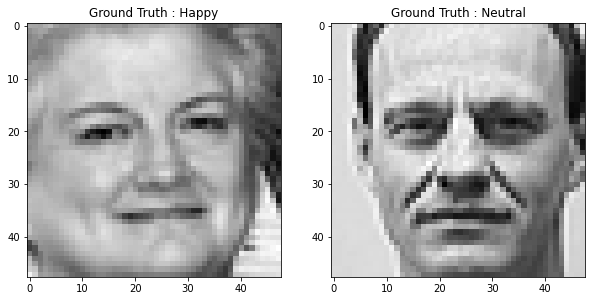

In [60]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[100,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(np.argmax(y_train[100]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[500,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(np.argmax(y_test[500]))))

In [67]:
np.save(path + 'X_train', X_train)
np.save(path + 'X_test', X_test)
np.save(path + 'X', X)
np.save(path + 'y_train', y_train)
np.save(path + 'y_test', y_test)
np.save(path + 'y', y)